<a href="https://colab.research.google.com/github/claubermartins/Stock-market-prediction/blob/main/stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
pip install inflection

#**1-Importando bibliotecas**

In [135]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import seaborn as sns
import datetime
import inflection
from IPython.core.display import HTML

#**2-Funções auxiliares para o Jupyter Notebook**

In [136]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [137]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


#**2.1Método de importação de arquivos do Google Colab**

In [138]:
from google.colab import files
upload = files.upload()
print("downloaded files: ")
print(*upload, sep = "\n")

Saving PETR4-teste.csv to PETR4-teste.csv
Saving PETR4-treinamento.csv to PETR4-treinamento.csv
downloaded files: 
PETR4-teste.csv
PETR4-treinamento.csv


#**3-Tratamento dos dados**

##**3.1-Importando os dados**

In [139]:
base = pd.read_csv('PETR4-treinamento.csv')
base = base.drop('Date', axis = 1)

In [140]:
#valores estatísticos
base.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2.231000e+03
mean,18.454940,18.715959,18.171054,18.424593,16.004749,3.986028e+07
std,6.621185,6.656502,6.574314,6.609528,5.024887,3.092003e+07
min,4.200000,4.270000,4.120000,4.200000,3.896351,0.000000e+00
25%,13.925000,14.140000,13.655000,13.950000,12.715022,2.139665e+07
50%,18.400000,18.680000,18.070000,18.350000,16.090048,3.287650e+07
75%,22.549999,22.825000,22.290000,22.559999,19.421658,5.199460e+07
max,37.430000,37.500000,37.070000,37.500000,29.229712,6.989506e+08


In [141]:
base.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

##**3.2-Tratando os Valores Faltantes**

In [142]:
#valores faltantes
base.isna().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [143]:
#encontrando onde os valores faltantes estão
base.loc[pd.isnull(base['Open'])]
base.loc[pd.isnull(base['High'])]
base.loc[pd.isnull(base['Low'])]
base.loc[pd.isnull(base['Close'])]
base.loc[pd.isnull(base['Adj Close'])]
base.loc[pd.isnull(base['Volume'])]

,Open,High,Low,Close,Adj Close,Volume
2015,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=0)
imputer = imputer.fit(base.iloc[:,0:6])
base.iloc[:,0:6] = imputer.transform(base.iloc[:,0:6])

In [145]:
#verificando novamente se ainda temos valores faltantes
base.loc[pd.isnull(base['Open'])]
base.loc[pd.isnull(base['High'])]
base.loc[pd.isnull(base['Low'])]
base.loc[pd.isnull(base['Close'])]
base.loc[pd.isnull(base['Adj Close'])]
base.loc[pd.isnull(base['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


#**3.3-Tratamento dos valores nulos (iguais a 0)**

In [146]:
#valores nulos
(base == 0).sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       54
dtype: int64

In [147]:
#Encontrando os valores nulos
base.loc[base['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume
99,27.809999,27.809999,27.809999,27.809999,21.897339,0.0
273,26.879999,26.879999,26.879999,26.879999,21.575644,0.0
274,26.879999,26.879999,26.879999,26.879999,21.575644,0.0
284,28.709999,28.709999,28.709999,28.709999,23.044519,0.0
291,29.080000,29.080000,29.080000,29.080000,23.341505,0.0
301,28.129999,28.129999,28.129999,28.129999,22.719036,0.0
305,28.350000,28.350000,28.350000,28.350000,22.896719,0.0
308,28.370001,28.370001,28.370001,28.370001,22.912872,0.0
319,26.530001,26.530001,26.530001,26.530001,21.426805,0.0
334,24.600000,24.600000,24.600000,24.600000,19.967300,0.0


In [148]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=0, strategy='mean',verbose=0)
imputer = imputer.fit(base.iloc[:,0:6])
base.iloc[:,0:6] = imputer.transform(base.iloc[:,0:6])

In [149]:
#Encontrando os valores nulos
base.loc[base['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [ ]:
#base = base.dropna()

In [ ]:
#base.sample()

#**-Descrição dos dados** IGNORE ESTA CÉLULA

In [ ]:
#Tendencia central - mean, median
ct1 = pd.DataFrame(base.apply(np.mean)).T #T transpondo 
ct2 = pd.DataFrame(base.apply(np.median)).T
#Dispersão - std(desvio padrão), min, max, range
d1 = pd.DataFrame(base.apply(np.std)).T
d2 = pd.DataFrame(base.apply(min)).T
d3 = pd.DataFrame(base.apply(max)).T
d4 = pd.DataFrame(base.apply(lambda x: x.max() - x.min())).T
#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1]).T.reset_index()
m.columns = ['attributes','min','max','range', 'mean', 'median', 'std']
m

,attributes,min,max,range,mean,median,std
0,Open,4.200000,3.743000e+01,3.323000e+01,1.933303e+01,1.909000e+01,6.833255e+00
1,High,4.270000,3.750000e+01,3.323000e+01,1.959720e+01,1.937000e+01,6.867448e+00
2,Low,4.120000,3.707000e+01,3.295000e+01,1.904492e+01,1.878000e+01,6.786986e+00
3,Close,4.200000,3.750000e+01,3.330000e+01,1.930418e+01,1.910000e+01,6.824516e+00
4,Adj Close,3.896351,3.054497e+01,2.664862e+01,1.705664e+01,1.670628e+01,5.745576e+00
5,Volume,0.000000,6.989506e+08,6.989506e+08,4.115402e+07,3.508690e+07,3.058053e+07


In [ ]:
base.shape[0]

2478

#**4-Treinamento da rede**

In [150]:
#normalizando a base de dados com o MinMaxScaler
base_treinamento = base.iloc[:, 0:6].values
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [151]:
#Comparando a predição com o preço real
previsores = []
preco_real = []
for i in range(90, 2232):
    previsores.append(base_treinamento_normalizada[i-90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)


In [152]:
#estrutura da rede neural 
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'loss', min_delta = 1e-15, patience = 20, verbose = 1)

#regressor.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
#                  metrics = ['mean_absolute_error'])
opt = tf.keras.optimizers.Adam(amsgrad=True)
regressor.compile(optimizer = opt, loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
#opt = tf.keras.optimizers.RMSprop(centered=True)
#regressor.compile(optimizer = opt, loss = 'mean_squared_error',
#                 metrics = ['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs = 600, batch_size = 32,
              callbacks = [es])

Epoch 1/600
67/67 [==============================] - 6s 18ms/step - loss: 0.0188 - mean_absolute_error: 0.1022
Epoch 2/600
67/67 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_absolute_error: 0.0448
Epoch 3/600
67/67 [==============================] - 1s 16ms/step - loss: 0.0026 - mean_absolute_error: 0.0393
Epoch 4/600
67/67 [==============================] - 1s 16ms/step - loss: 0.0026 - mean_absolute_error: 0.0388
Epoch 5/600
67/67 [==============================] - 1s 15ms/step - loss: 0.0020 - mean_absolute_error: 0.0346
Epoch 6/600
67/67 [==============================] - 1s 15ms/step - loss: 0.0021 - mean_absolute_error: 0.0355
Epoch 7/600
67/67 [==============================] - 1s 16ms/step - loss: 0.0017 - mean_absolute_error: 0.0321
Epoch 8/600
67/67 [==============================] - 1s 15ms/step - loss: 0.0015 - mean_absolute_error: 0.0298
Epoch 9/600
67/67 [==============================] - 1s 15ms/step - loss: 0.0016 - mean_absolute_error: 0.0301
E

#**5-Teste da rede**

##**5.1-Importando os dados para teste**

In [153]:
#criando a base de dados teste
base_teste = pd.read_csv('PETR4-teste.csv')
base_teste = base_teste.drop('Date', axis = 1)

In [154]:
#valores estatísticos
base_teste.describe()

,Open,High,Low,Close,Adj Close,Volume
count,247.000000,247.000000,247.000000,247.000000,247.000000,2.470000e+02
mean,27.264291,27.556883,26.938057,27.248988,26.557694,5.283958e+07
std,1.668801,1.658077,1.648094,1.655566,1.724097,2.451955e+07
min,22.549999,24.190001,22.280001,23.910000,23.284782,1.904990e+07
25%,26.155000,26.370001,25.814999,26.064999,25.310672,3.731705e+07
50%,27.150000,27.430000,26.870001,27.129999,26.422461,4.850220e+07
75%,28.205000,28.445000,27.870001,28.220001,27.386540,6.118210e+07
max,30.889999,31.230000,30.500000,30.969999,30.544973,2.273076e+08


##**5.2-Tratando os Valores Faltantes**

In [155]:
#valores faltantes
base_teste.isna().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [156]:
#encontrando onde os valores faltantes estão
base_teste.loc[pd.isnull(base_teste['Open'])]
base_teste.loc[pd.isnull(base_teste['High'])]
base_teste.loc[pd.isnull(base_teste['Low'])]
base_teste.loc[pd.isnull(base_teste['Close'])]
base_teste.loc[pd.isnull(base_teste['Adj Close'])]
base_teste.loc[pd.isnull(base_teste['Volume'])]

,Open,High,Low,Close,Adj Close,Volume
42,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
#preenchendo os valores faltantes com o valor médio
imputer = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=0)
imputer = imputer.fit(base_teste.iloc[:,0:6])
base_teste.iloc[:,0:6] = imputer.transform(base_teste.iloc[:,0:6])

In [159]:
#verificando novamente se ainda temos valores faltantes
base_teste.loc[pd.isnull(base_teste['Open'])]
base_teste.loc[pd.isnull(base_teste['High'])]
base_teste.loc[pd.isnull(base_teste['Low'])]
base_teste.loc[pd.isnull(base_teste['Close'])]
base_teste.loc[pd.isnull(base_teste['Adj Close'])]
base_teste.loc[pd.isnull(base_teste['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


#**5.3-Tratamento dos valores nulos (iguais a 0)**

In [160]:
#valores nulos
(base_teste == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [124]:
#Encontrando os valores nulos
base_teste.loc[base_teste['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [125]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=0, strategy='mean',verbose=0)
imputer = imputer.fit(base_teste.iloc[:,0:6])
base_teste.iloc[:,0:6] = imputer.transform(base_teste.iloc[:,0:6])

In [126]:
#Verificando novamente se tem valores nulos
base_teste.loc[base_teste['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


##**5.4-Preparando a estrutura para teste**

In [161]:
#concatenando a base de dados teste com o base de treinamento
preco_real_teste = base_teste.iloc[:, 3:4].values
frames = [base, base_teste]
base_completa = pd.concat(frames)

In [162]:
#pegando os 90 registros anteriores para percorrer a base teste e colocando no
#no formato np.array
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = normalizador.transform(entradas)
Percorrer_teste = []
for i in range(90, 338): 
    Percorrer_teste.append(entradas[i-90:i, 0:6])
Percorrer_teste = np.array(Percorrer_teste)

In [163]:
#resultado da predição no formato MinMaxScaler
previsoes = regressor.predict(Percorrer_teste)

In [164]:
#convertendo para a escala MinMaxScaler 
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,3:4])

array([[0.99459459],
       [0.98498498],
       [1.        ],
       ...,
       [0.52492492],
       [0.52462462],
       [0.55495495]])

In [165]:
#visualisando a previsão com no formato original
previsoes = normalizador_previsao.inverse_transform(previsoes)

##**6-Análise dos resuldatos**

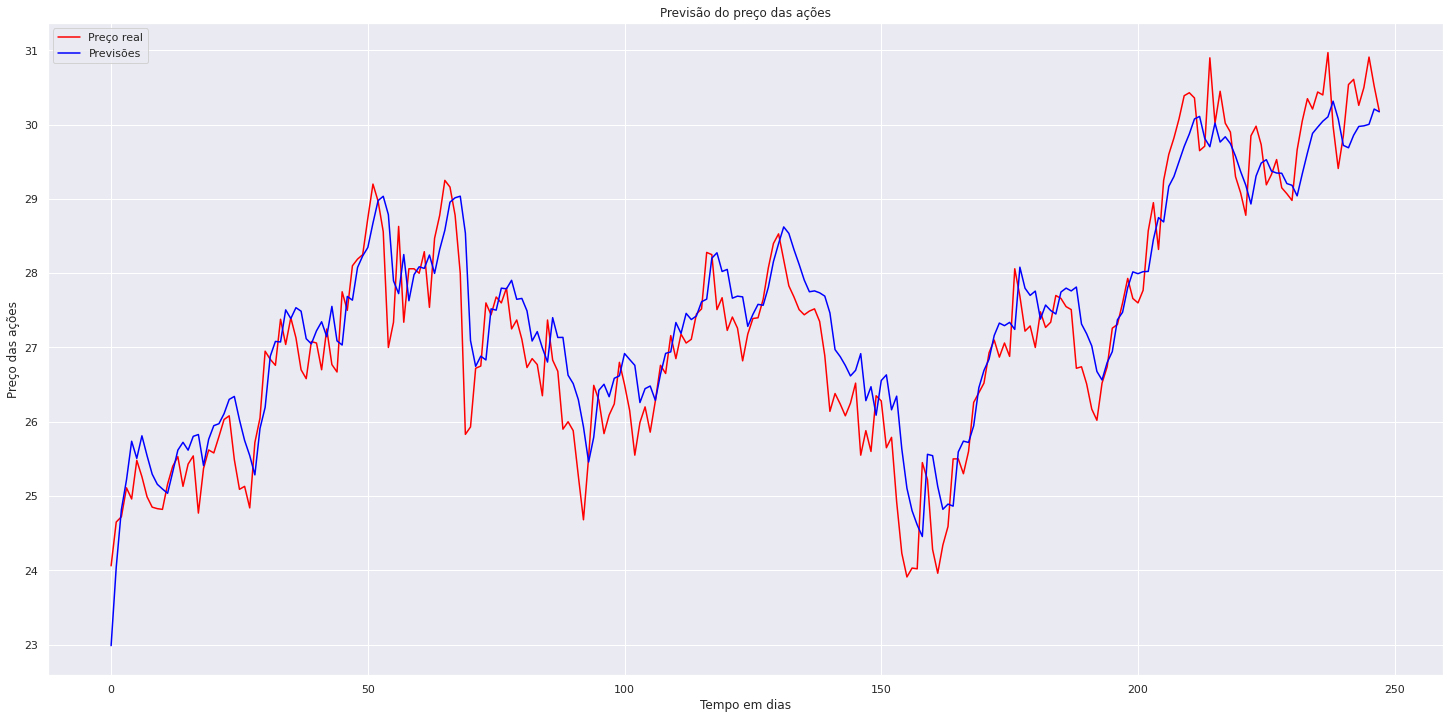

In [166]:
#Visualizando o gráfico da Previsão da rede
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão do preço das ações')
plt.xlabel('Tempo em dias')
plt.ylabel('Preço das ações')
plt.legend()
plt.show()

In [168]:
previsoes.mean()

27.431877

In [169]:
preco_real_teste.mean()

27.248987858299596